<a href="https://colab.research.google.com/github/nibess1/QNNVis/blob/main/PennylaneQNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 42.1 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer


Below is how to create a random circuit. Based on the seed, the circuit generated will always be constant. Increasing weights increases the number of parameters of circuit.

In [ ]:
dev = qml.device("default.qubit", wires = 16)

@qml.qnode(dev)
def circuit(theta):
  qml.PauliX(wires = 0)
  qml.RY(theta, wires = 0)
  qml.CNOT([0, 1])
  return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1))

circuit(0.1)

(tensor(-0.99500417, requires_grad=True), tensor(0., requires_grad=True))

In [17]:
import tensorflow as tf
from tensorflow import keras

In [18]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [19]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 150    # Size of the train dataset
n_test = 30     # Size of the test dataset

# original [30 , 1 , 100, 30 ]
# new model -> increased epochs to see if bigger improvements can be made
# doubled train and test images to see if more samples will signiicantly improve performance.

#modded to wd
#SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
# SAVE_PATH = "/content/_static/demonstration_assets/quanvolution"
SAVE_PATH = "/content/"

PREPROCESS = False     # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)     # Seed for NumPy random number generator
tf.random.set_seed(0) # Seed for TensorFlow random number generator

In [20]:

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]



# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False) # note, requies_grad : BOOL = False is an adaptation of numpy made by pennylane.
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)   # normal numpy and numpy autograd both dont have this.

In [21]:
train_images[0].reshape(28,28)

tensor([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

Code to downsample the image from 28 x 28 to 4x4. Then using 16 qubit simulation by performing angle encoding. An alternative solution might be to use angle encoding in the X,Y,Z plane of the bloch spehere, and lower the number of qubits required.

Experiment 2: angle encoding of 6x6 downsample, with 12 qubits

Experiment 3: angle encoding of 3x3 downsample, with 3 qubits

In [40]:

def downsample_image(image, new_size=(4, 4)):
    """
    Downsamples a given 28x28 image to a specified size using average pooling.

    Args:
    image (np.array): A 28x28 numpy array representing the image.
    new_size (tuple): The desired dimensions (height, width) of the downsampled image.

    Returns:
    np.array: The downsampled image.
    """
    # Calculate the size of the pooling window
    height, width = image.shape
    new_height, new_width = new_size
    pool_height = height // new_height
    pool_width = width // new_width

    # Initialize the output image with zeros
    downsampled = np.zeros(new_size, requires_grad = False)

    # Loop over each block in the output image
    for i in range(new_height):
        for j in range(new_width):
            # Calculate the starting and ending indices of the window
            start_i = i * pool_height
            end_i = start_i + pool_height
            start_j = j * pool_width
            end_j = start_j + pool_width

            # Calculate the average of the current window
            window = image[start_i:end_i, start_j:end_j]
            downsampled[i, j] = np.mean(window)

    return downsampled

# Example usage:
# Assuming `image` is a 28x28 numpy array representing an MNIST digit
downsampled_image = downsample_image(train_images[2].reshape(28,28), (4,4))
print(downsampled_image)
img = np.reshape(downsampled_image, 16)


[[0.01144458 0.         0.01496599 0.03921569]
 [0.24497799 0.         0.26706683 0.05106042]
 [0.1454982  0.22408964 0.38367347 0.        ]
 [0.         0.         0.17406963 0.        ]]


In [23]:
import matplotlib.pyplot as plt


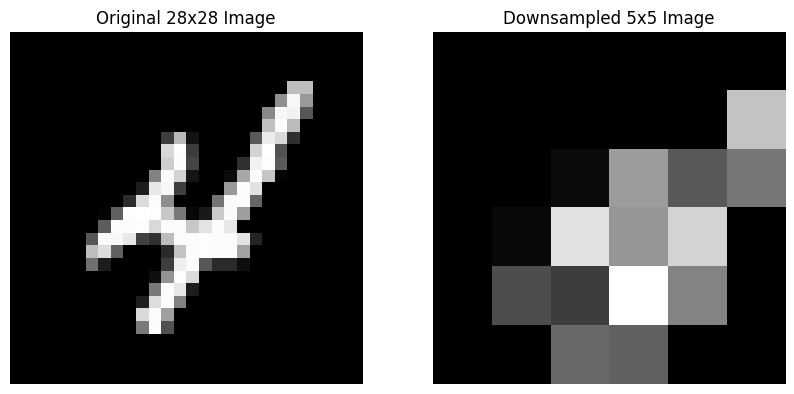

In [38]:
img_num = 9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_images[img_num].reshape(28,28), cmap='gray', interpolation='nearest')
ax[0].set_title('Original 28x28 Image')
ax[0].axis('off')

ax[1].imshow(downsample_image(train_images[img_num].reshape(28,28), (6,6)), cmap='gray', interpolation='nearest')
ax[1].set_title('Downsampled 5x5 Image')
ax[1].axis('off')

plt.show()

I am following a random guide I found online. They call each qubit and its tranformations wires.

https://pennylane.ai/qml/demos/tutorial_variational_classifier/

\
Here we initialise 4 wires, with a random rotation gate, and link each gate with a CNOT. 0-1, 1-2, 2-3, 3-0. Might experiment with different configurations later if i manage to get it working.

In [39]:
dev = qml.device('default.qubit', wires=5)

@qml.qnode(dev)
def encode(feature_vector):
    qml.AngleEmbedding(features=feature_vector[:5], wires=range(5), rotation='X')
    qml.AngleEmbedding(features=feature_vector[5:10], wires=range(5), rotation='Y')
    qml.AngleEmbedding(features=feature_vector[10:15], wires=range(5), rotation='Z')
    qml.Hadamard(0)
    return qml.probs(wires=range(4))

In [43]:
 print(qml.draw(encode, expansion_strategy="device")(img))

0: ──RX(0.01)──RY(0.00)──RZ(0.38)──H─┤ ╭Probs
1: ──RX(0.00)──RY(0.27)──RZ(0.00)────┤ ├Probs
2: ──RX(0.01)──RY(0.05)──RZ(0.00)────┤ ├Probs
3: ──RX(0.04)──RY(0.15)──RZ(0.00)────┤ ╰Probs
4: ──RX(0.24)──RY(0.22)──RZ(0.17)────┤       


encoding is now completed. Now we need to pass on the quantum information into the ansatz. \
  1) Design an ansatz using random circuit \
  2) Somehow layer that
  3) Pass in parameters

In [50]:

dev = qml.device("default.qubit", wires=5)
weights = np.zeros((15,1))

def subroutine(weights):
    qml.RandomLayers(weights=weights, wires=range(5))
    return qml.expval(qml.Z(0))

@qml.qnode(dev)
def circuit1(weights):
  qml.layer(subroutine(weights), 3)
  return [qml.expval(qml.Z(0)), qml.expval(qml.Z(1))]


print(qml.draw(circuit1, expansion_strategy="device")(weights))

TypeError: 'ExpectationMP' object is not callable

state_prepartion(x) converts x into its quantum state.

\

For example: 0101 becomes |0101>

In [ ]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

I am guessing that the weights refer to the number of parameters that can be controlled for. The circuit would be constructed by the layer we defined earlier, which would be repeated for the number of parameters we want to control.

__

Do not know what `qml.expval(qml.PauliZ(0))` does.

In [ ]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

If we want to add a “classical” bias parameter, the variational quantum classifier also needs some post-processing. We define the full model as a sum of the output of the quantum circuit, plus the trainable bias
_____
\


Neural networks typically have weights and biases. We are adding a classical bias instead of a quantum one. Not sure why.

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In supervised learning, the cost function is usually the sum of a loss function and a regularizer. We restrict ourselves to the standard square loss that measures the distance between target labels and model predictions.

\

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy, or the proportion of predictions that agree with a set of target labels.

In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

Now we use the square loss function to return the cost of our predictions

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)